In [89]:
# Author: Hussain Abbas, MSc
# © 2021 Stats AI LLC 
# All Rights Reserved

import pandas as pd
import numpy as np
from fbprophet import Prophet
from tqdm import tqdm

In [90]:
df = pd.read_csv('C:/Users/deepl/Desktop/Online Retail Forecasting/Online Retail/Online Retail.csv',
                 encoding = 'unicode_escape')

In [91]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [93]:
# clean up column names
df.columns = ['invoice_no', 'stock_code', 'desc', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

# convert dates into date_time format
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# convert customer_id to object type
df[['customer_id']] = df[['customer_id']].astype(object)

In [94]:
# there are no orders for 12/3/11

dfs = df[df.invoice_date.between('2011-11-27', '2011-12-03')]
dfs

,invoice_no,stock_code,desc,quantity,invoice_date,unit_price,customer_id,country
502744,578848,22768,FAMILY PHOTO FRAME CORNICE,1,2011-11-27 10:34:00,9.95,17988,United Kingdom
502745,578848,23156,SET OF 5 MINI GROCERY MAGNETS,2,2011-11-27 10:34:00,2.08,17988,United Kingdom
502746,578849,22847,BREAD BIN DINER STYLE IVORY,1,2011-11-27 10:39:00,16.95,13232,United Kingdom
502747,578849,22846,BREAD BIN DINER STYLE RED,1,2011-11-27 10:39:00,16.95,13232,United Kingdom
502748,578849,22853,CAT BOWL VINTAGE CREAM,3,2011-11-27 10:39:00,3.25,13232,United Kingdom
...,...,...,...,...,...,...,...,...
522160,580379,72225C,NaN,-144,2011-12-02 17:57:00,0.00,NaN,United Kingdom
522161,580380,21620,check,-20,2011-12-02 17:58:00,0.00,NaN,United Kingdom
522162,580381,21758,NaN,-9,2011-12-02 17:58:00,0.00,NaN,United Kingdom
522163,580382,16045,check,-900,2011-12-02 17:59:00,0.00,NaN,United Kingdom


In [95]:
# returns the top 3 selling products for the time period

top_products = dfs.groupby('stock_code').sum().sort_values('quantity', ascending = False).iloc[:3].reset_index()
search_values = pd.Series.tolist(top_products.stock_code)
search_values

['23084', '22197', '23582']

In [96]:
# create a new dataframe for training that contains the top selling products

train_data = df[df.stock_code.str.contains('|'.join(search_values ))]
train_data[train_data.invoice_date < '2011-11-27']

# create a new dataframe that aggregates intraday data at the daily level 

train_data_daily = train_data.groupby(['country', 'stock_code']).resample('D', on = 'invoice_date').sum()
train_data_daily = train_data_daily[['quantity']]
train_data_daily = train_data_daily.reset_index()

# rename columns to prep data for Prophet

train_data_daily.columns = ['country','stock_code', 'ds', 'y']
train_data_daily

,country,stock_code,ds,y
0,Australia,23084,2011-05-12,12
1,Australia,23084,2011-05-13,0
2,Australia,23084,2011-05-14,0
3,Australia,23084,2011-05-15,0
4,Australia,23084,2011-05-16,0
...,...,...,...,...
5627,Unspecified,23084,2011-11-20,0
5628,Unspecified,23084,2011-11-21,0
5629,Unspecified,23084,2011-11-22,0
5630,Unspecified,23084,2011-11-23,0


<AxesSubplot:title={'center':'Daily Quantity\n Top 3 Products, All Countries'}, xlabel='index_value', ylabel='quantity'>

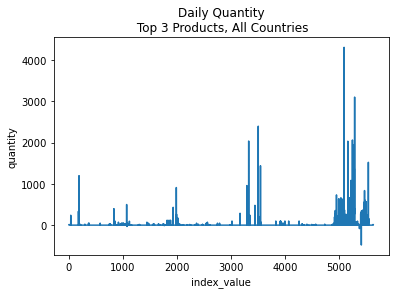

In [97]:
train_data_daily.y.plot(title = 'Daily Quantity\n Top 3 Products, All Countries', 
                           xlabel = 'index_value', ylabel = 'quantity')

In [98]:
np.quantile(train_data_daily.y, [0, 0.025, 0.5, 0.9750, 1])

array([-482.,    0.,    0.,  144., 4313.])

In [99]:
#most of the orders come from the UK

train_data_daily.country.value_counts()

United Kingdom     633
France             581
EIRE               553
Germany            549
Spain              474
Norway             404
Italy              379
Singapore          263
Netherlands        212
Channel Islands    203
Belgium            189
Australia          188
Iceland            182
Denmark            175
Japan              168
Sweden             167
Finland            164
Unspecified         85
Portugal            45
Switzerland         14
Israel               1
Poland               1
Greece               1
Cyprus               1
Name: country, dtype: int64

In [100]:
df[(df['country'] == 'Australia') & (df['stock_code'] == '23084')]

,invoice_no,stock_code,desc,quantity,invoice_date,unit_price,customer_id,country
187252,552956,23084,RABBIT NIGHT LIGHT,12,2011-05-12 12:34:00,2.08,12431,Australia
228193,556917,23084,RABBIT NIGHT LIGHT,240,2011-06-15 13:37:00,1.79,12415,Australia
436426,574138,23084,RABBIT NIGHT LIGHT,96,2011-11-03 11:26:00,1.79,12415,Australia
439360,574469,23084,RABBIT NIGHT LIGHT,336,2011-11-04 11:55:00,1.79,12431,Australia
468139,576394,23084,RABBIT NIGHT LIGHT,960,2011-11-15 10:32:00,1.79,12415,Australia
469139,576586,23084,RABBIT NIGHT LIGHT,240,2011-11-15 14:22:00,1.79,12415,Australia


## UK Top Product Forecast Test Run

In [101]:
# rename columns to prep data for Prophet

train_data_daily_uk = train_data_daily[(train_data_daily['country'] == 'United Kingdom') 
                                       & (train_data_daily['stock_code'] == search_values[0])]
train_data_daily_uk

,country,stock_code,ds,y
5288,United Kingdom,23084,2011-05-10,2
5289,United Kingdom,23084,2011-05-11,71
5290,United Kingdom,23084,2011-05-12,17
5291,United Kingdom,23084,2011-05-13,16
5292,United Kingdom,23084,2011-05-14,0
...,...,...,...,...
5497,United Kingdom,23084,2011-12-05,354
5498,United Kingdom,23084,2011-12-06,240
5499,United Kingdom,23084,2011-12-07,283
5500,United Kingdom,23084,2011-12-08,570


<AxesSubplot:title={'center':'Daily Quantity\n Product = 23084, Country = UK'}, xlabel='index_value', ylabel='quantity'>

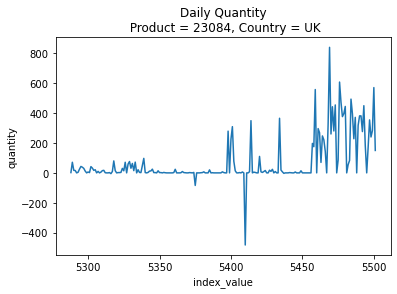

In [102]:
train_data_daily_uk.y.plot(title = 'Daily Quantity\n Product = ' + str(search_values[0]) + ', Country = UK',
                           xlabel = 'index_value', ylabel = 'quantity')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


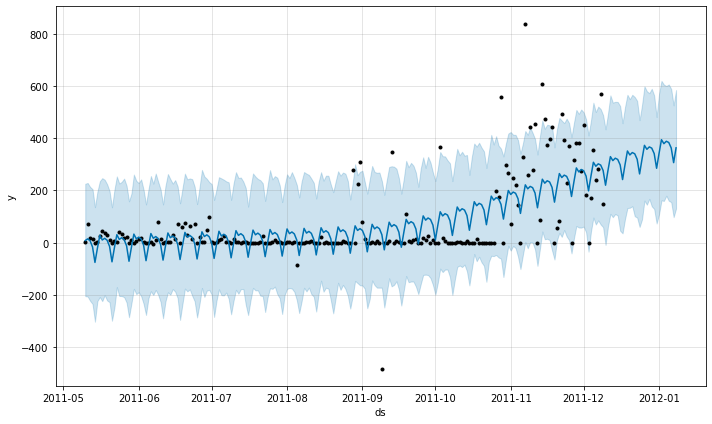

In [103]:
m = Prophet(weekly_seasonality = True, daily_seasonality = True, interval_width = 0.95)
m.fit(train_data_daily_uk)

# The last order date isn't necessarily the day before the start of the range we're forecasting. 
# Thus, we forecast 365 days out to be safe and then return the date range of interest

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot(forecast);

In [104]:
forecast = forecast[forecast.ds.between('2011-11-27', '2011-12-03')].reset_index()

actual = train_data_daily_uk[train_data_daily_uk.ds.between('2011-11-27', '2011-12-03')].reset_index()['y']
forecast['actual'] = actual

forecast['actual_within_CI'] = (forecast['actual'] > forecast['yhat_lower']) & (forecast['actual'] < forecast['yhat_upper'])
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actual', 'actual_within_CI']]

forecast

,ds,yhat,yhat_lower,yhat_upper,actual,actual_within_CI
0,2011-11-27,233.635255,16.591719,458.955112,317,True
1,2011-11-28,286.447956,64.141497,508.570475,381,True
2,2011-11-29,271.222913,58.128477,493.351132,381,True
3,2011-11-30,280.451973,57.858150,510.215645,276,True
4,2011-12-01,275.712136,61.720977,499.334411,449,True
5,2011-12-02,254.992993,40.123830,472.483426,181,True
6,2011-12-03,198.604575,-34.271931,410.704225,0,True


## All Countries, Top 3 Products Forecasts

In [105]:
def get_prediction(df):
    
    predictions = []
    countries = tqdm(df.country.unique())
    products = df.stock_code.unique()

    for country in countries:
        
        for product in products: 
                    
            df_subset = df[(df['country'] == country) & (df['stock_code'] == product)]
            
            try:
                
                # We need to wrap this in a try-except block since Prophet fails if our time series is less than 2 values
                # We set the Confidence Interval to 95%
                # We remove yearly seasonality since we have less than a year of data
                # The last order date isn't necessarily the day before the start of the range we're forecasting. 
                # Thus, we forecast 365 days out to be safe and then return the date range of interest

                m = Prophet(weekly_seasonality = True, daily_seasonality = True, interval_width = 0.95)
                m.fit(df_subset)
        
                future = m.make_future_dataframe(periods = 365)
                forecast = m.predict(future)
        
                forecast['stock_code'] = product
                forecast['country'] = country
                forecast = forecast[['ds', 'country', 'stock_code','yhat', 'yhat_lower', 'yhat_upper']]
                forecast = forecast[forecast.ds.between('2011-11-27', '2011-12-03')]

                predictions.append(forecast)
            
            except:
                
                continue
        
    return pd.concat(predictions)

In [106]:
result = get_prediction(train_data_daily)
result

 21%|█████████████████▎                                                                 | 5/24 [00:07<00:32,  1.71s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
 29%|████████████████████████▏                                                          | 7/24 [00:13<00:37,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
 33%|███████████████████████████▋                                                       | 8/24 [00:21<01:01,  3.81s/it]INFO:fbprophet:Disabling yearly seasonality. R

,ds,country,stock_code,yhat,yhat_lower,yhat_upper
199,2011-11-27,Australia,23084,51.335997,-120.597949,221.057298
200,2011-11-28,Australia,23084,51.804285,-125.617685,227.767771
201,2011-11-29,Australia,23084,96.750040,-76.420176,271.491541
202,2011-11-30,Australia,23084,63.701165,-113.503885,232.182048
203,2011-12-01,Australia,23084,59.499269,-116.842638,235.179344
...,...,...,...,...,...,...
88,2011-11-29,Unspecified,23084,0.400717,-2.018966,2.719357
89,2011-11-30,Unspecified,23084,0.400909,-2.143367,2.862649
90,2011-12-01,Unspecified,23084,1.401098,-1.112790,3.751379
91,2011-12-02,Unspecified,23084,0.545354,-1.876362,2.832271


In [107]:
result.to_csv('hussain_abbas_result.csv',index=False)